In [1]:
%config Completer.use_jedi = False
%load_ext autoreload
%autoreload 2

In [2]:
import cv2
import numpy as np
from wm import Image as PolarImage
from PIL import Image

In [3]:
from wm.moments import RadialHarmonicFourierMoment
from wm.moments import ZernikeMoment, PseudoZernikeMoment

In [4]:
from wm.metrics import PSNR

## Embedding

In [5]:
L = 64
# data
np.random.seed(0)
data = np.random.randint(2, size=L)
pos = np.array(range(len(data)))

In [6]:
#data = np.array(list(map(int, '011101110110000101110100011001010111001001101101011000010111001001101011')))

In [7]:
data

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1,
       1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0])

In [8]:
%%time
W = 256
order = int(np.sqrt(L)*4)
# method
method = ZernikeMoment(order+1, W, Vfile='V_'+'ZM'+'_'+str(W)+'.h5')

CPU times: user 932 ms, sys: 2.35 s, total: 3.28 s
Wall time: 24 s


In [9]:
# image
pim = PolarImage('images/monochrome/lena_'+str(W)+'.png', colored=False)
pime = method.encode(pim, data, verbose=True)
im = Image.fromarray(pime.im)

In [11]:
#im.save(''.join(['lena_',str(W),'_'+method.name+'_','N',str(order),'L',str(L),'.png']))

In [12]:
imdiff = np.abs(pim.im.astype('float16') - pime.im.astype('float16')).astype('uint8')
II = PolarImage(10*imdiff, colored=False)

In [13]:
#Image.fromarray(II.im).save(''.join(['lena_',str(W),'_'+method.name+'_diff_','N',str(order),'L',str(L),'.png']))

PSNR 40.59299968451022 dB


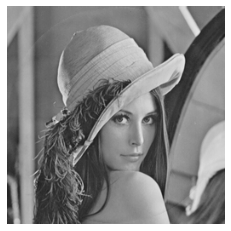

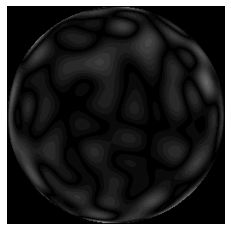

In [14]:
print('PSNR', PSNR(pim.im, pime.im), 'dB')
pime.show()
II.show()

## Benchmarks

In [122]:
from wm.benchmarks.geometry import Resize, Rotate, Flip
from wm.benchmarks.noise import Blur, Sharpen, Median, SaltPapperNoise, WhiteNoise
from wm.benchmarks.enhance import Contrast, Brightness
from wm.benchmarks.compression import JPEG, JPEG2000, WebP

In [101]:
# RESIZE
scales = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.1, 1.2, 1.3, 1.4, 1.5, 2, 3]
bs_resize_linear  = [ Resize(method, data, pos=pos, scale=s, resample=Image.LINEAR,  name='Resize/Linear/'+str(s))  for s in scales ]
bs_resize_bicubic = [ Resize(method, data, pos=pos, scale=s, resample=Image.BICUBIC, name='Resize/Bicubic/'+str(s)) for s in scales ]
# ROTATE
angles = [1, 2, 3, 4, 5, 10, 15, 20, 25, 30, 35, 40, 45]
bs_rotate_linear  = [ Rotate(method, data, pos=pos, angle=a, resample=Image.LINEAR,  name='Rotate/Linear/'+str(a))  for a in angles ]
bs_rotate_bicubic = [ Rotate(method, data, pos=pos, angle=a, resample=Image.BICUBIC, name='Rotate/Bicubic/'+str(a)) for a in angles ]
# FLIP
flips = [Image.FLIP_LEFT_RIGHT, Image.FLIP_TOP_BOTTOM]
bs_flip = [ Flip(method, data, pos=pos, direction=d, name='Flip/'+str('UD' if d else 'LR')) for d in flips ]

In [102]:
# GAUSSBLUR
blurs = [ 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5, 2.75, 3 ]
bs_blur_3 = [ Blur(method, data, pos=pos, size=(3,3), sigma=s, name='Blur/3x3/'+str(s)) for s in blurs ]
bs_blur_5 = [ Blur(method, data, pos=pos, size=(3,3), sigma=s, name='Blur/5x5/'+str(s)) for s in blurs ]
bs_blur_7 = [ Blur(method, data, pos=pos, size=(3,3), sigma=s, name='Blur/7x7/'+str(s)) for s in blurs ]
# SHARPEN
sharpens = [ 2, 2.25, 2.5, 2.75, 3, 3.25, 3.5, 3.75, 4 ]
bs_sharpen_3 = [ Sharpen(method, data, pos=pos, size=(3,3), sigma=2, ratio=r, name='Sharpen/3x3/'+str(r)) for r in sharpens ]
bs_sharpen_5 = [ Sharpen(method, data, pos=pos, size=(3,3), sigma=2, ratio=r, name='Sharpen/5x5/'+str(r)) for r in sharpens ]
bs_sharpen_7 = [ Sharpen(method, data, pos=pos, size=(3,3), sigma=2, ratio=r, name='Sharpen/7x7/'+str(r)) for r in sharpens ]
# MEDIAN
medians = [ 3, 5, 7, 9 ]
bs_median = [ Median(method, data, pos=pos, size=s, name='Median/'+str(s)) for s in medians ]
# SALTPEPPER
sps = [0.001, 0.005, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]
bs_saltpepper = [ SaltPapperNoise(method, data, pos=pos, amount=a, name='SaltPepper/'+str(a)) for a in sps ]
# WHITENOISE
wn = [ 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
bs_whitenoise = [ WhiteNoise(method, data, pos=pos, ratio=r, name='WhiteNoise/'+str(r)) for r in wn ]

In [123]:
# CONTRAST
contrasts = [ 0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2]
bs_contrast = [ Contrast(method, data, pos=pos, factor=f, name='Contrast/'+str(f)) for f in contrasts ]
# BRIGHTNESS
brightnesses = [ 0.8, 0.9, 0.95, 1, 1.05, 1.1, 1.2]
bs_brightness = [ Brightness(method, data, pos=pos, factor=f, name='Brightness/'+str(f)) for f in contrasts ]

In [114]:
# JPEG
qualities = [100, 90, 80, 70, 60, 50, 40, 30, 25, 20, 15, 10, 5]
bs_jpeg =     [ JPEG(method, data, pos=pos, quality=q, name='JPEG/'+str(q)) for q in qualities ]
bs_jpeg2000 = [ JPEG2000(method, data, pos=pos, name='JPEG2000') ]
bs_webp =     [ WebP(method, data, pos=pos, quality=q, name='WebP/'+str(q)) for q in qualities ]

### Run

In [115]:
from functools import reduce
from wm.benchmarks.Benchmark import Benchmark

In [126]:
bs_ = reduce(lambda a,b: a+b, [
    # GEOMETRY
    bs_resize_linear, bs_resize_bicubic,
    bs_rotate_linear, bs_rotate_bicubic,
    bs_flip,
    # FILTER
    bs_blur_3, bs_blur_5, bs_blur_7,
    bs_sharpen_3, bs_sharpen_5, bs_sharpen_7,
    bs_median,
    # ENHANCE
    bs_contrast, bs_brightness,
    # NIOSE
    bs_saltpepper, bs_whitenoise,
    # COMPRESSION
    bs_jpeg, bs_jpeg2000, bs_webp,
], [])

In [127]:
%%time
print(Benchmark(method, data, pos=pos)(im))
for b in bs_:
    res = b(im)
    print(''.join([b.name, '\t', str(res)]))

1.0
Resize/Linear/0.2	0.5
Resize/Linear/0.3	0.59375
Resize/Linear/0.4	0.765625
Resize/Linear/0.5	0.890625
Resize/Linear/0.6	0.96875
Resize/Linear/0.7	0.984375
Resize/Linear/0.8	1.0
Resize/Linear/0.9	1.0
Resize/Linear/1.1	1.0
Resize/Linear/1.2	1.0
Resize/Linear/1.3	1.0
Resize/Linear/1.4	1.0
Resize/Linear/1.5	1.0
Resize/Linear/2	1.0
Resize/Linear/3	1.0
Resize/Bicubic/0.2	0.5
Resize/Bicubic/0.3	0.59375
Resize/Bicubic/0.4	0.765625
Resize/Bicubic/0.5	0.890625
Resize/Bicubic/0.6	0.96875
Resize/Bicubic/0.7	0.984375
Resize/Bicubic/0.8	1.0
Resize/Bicubic/0.9	1.0
Resize/Bicubic/1.1	1.0
Resize/Bicubic/1.2	1.0
Resize/Bicubic/1.3	1.0
Resize/Bicubic/1.4	1.0
Resize/Bicubic/1.5	1.0
Resize/Bicubic/2	1.0
Resize/Bicubic/3	1.0
Rotate/Linear/1	1.0
Rotate/Linear/2	1.0
Rotate/Linear/3	1.0
Rotate/Linear/4	1.0
Rotate/Linear/5	1.0
Rotate/Linear/10	1.0
Rotate/Linear/15	1.0
Rotate/Linear/20	1.0
Rotate/Linear/25	1.0
Rotate/Linear/30	1.0
Rotate/Linear/35	1.0
Rotate/Linear/40	1.0
Rotate/Linear/45	1.0
Rotate/Bicubic/

In [128]:
method.unloadVfile()